dataset:

---

https://github.com/liaopeiyuan/artbench

Ideas how to handle dataset, since it is now inbalanced

https://medium.com/@serverwalainfra/how-to-handle-imbalanced-datasets-with-fastai-d7e51cbf83f7

oversampling

https://www.kaggle.com/code/tanlikesmath/oversampling-mnist-with-fastai#Creating-imbalanced-dataset

# Experiments in this notebook

**14.) Train on reduced dataset:**


Idea: We know from EDA on dataset that certain artists appear in the dataset for multiple genres. For example, both impressionism and post_impressionism, are 2 genres that are often confused and we know that artists from one of these genres appear in the other very often. Do these artists make the problem harder? What would happen if we train on a simpler dataset, where all artists appear only in one genre? Repeat the training in the same style as 013, but on this reduced dataset.

Result: Results are better known, but the model starts to overfit after a while. We also see that the dataset is imbalanced now.Certain genres have fewer paintings now, even more than 50% less, while other genres have not had much reduction.

Conclusion: Repeat the process again, but use the Early Stoppage callback.

**15.) Train on reduced dataset early stoppage:**


Idea: Retrain the same way as 015, but use early stoppage, so that when the model does not improve, for several consecutive epochs, we get results with the least error.

Result: Early stoppage helps, we finish training sooner without starting to overfit on the validation set.

Conclusion: TODO: analyse the results with the learner from experiment 013. Take into account that certain genres have fewer records now.


# Import of libraries, creation of the experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 17.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
# load mlflow.db from the google drive, so experiments will be present, but without any artifacts
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
!ls '/content'

drive  mlruns.db  sample_data  utils


In [ ]:
from artworks_helpers import *
from fastai_utils import *
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/08/10 19:20:37 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/10 19:20:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

In [ ]:
# load only certain experiment from mlflow when needed, but create folders before
!mkdir -p /content/mlruns
!mkdir -p /content/mlruns/{active_experiment_id}

In [ ]:
print('current number of completed runs in experiment')
print(len(mlfclient.search_runs(experiment_ids=[active_experiment_id])))

current number of completed runs in experiment
15


# Preparation of reduced dataset, where paintings by artists in multiple genres are removed

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar', data='/content/artbench-reduced')

In [ ]:
import os

In [ ]:
df_original = pd.read_csv("https://artbench.eecs.berkeley.edu/files/ArtBench-10.csv")

In [ ]:
artist_by_number_of_genres   = df_original.groupby('artist')['label'].nunique().reset_index(name='genres_count').sort_values(by='genres_count', ascending=False)
artists_with_multiple_genres = artist_by_number_of_genres[artist_by_number_of_genres['genres_count'] > 1]

In [ ]:
mask = df_original['artist'].isin(artists_with_multiple_genres['artist'].values)
df_original['multiple_genres'] = False
df_original.loc[mask, 'multiple_genres']  = True

Remove files in the download folder where artist occur accross genres

In [ ]:
for _, row in (df_original[df_original['multiple_genres'] == True]).iterrows():
    file_path = path / row['split'] / row['label'] / row['name']
    if file_path.exists():
      os.remove(file_path)

In [ ]:
df = df_original.drop(df_original[df_original['multiple_genres']== True].index)
df.drop(columns=['multiple_genres'], inplace=True)

**Certain genres now have less records, need to change the data split then**

In [ ]:
df_original[df_original['split'] == 'train'].shape[0], df_original[df_original['split'] == 'test'].shape[0]

(50000, 10000)

In [ ]:
df[df['split'] == 'train'].shape[0], df[df['split'] == 'test'].shape[0]

(32878, 6650)

In [ ]:
df[df['split'] == 'train'].groupby('label').size().reset_index(name='count').sort_values(by='count', ascending=True)

,label,count
3,impressionism,1585
4,post_impressionism,1596
0,art_nouveau,2030
5,realism,2049
2,expressionism,2698
7,romanticism,4012
8,surrealism,4176
6,renaissance,4805
1,baroque,4928
9,ukiyo_e,4999


In [ ]:
df[df['split'] == 'test'].groupby('label').size().reset_index(name='count').sort_values(by='count', ascending=True)

,label,count
4,post_impressionism,281
3,impressionism,324
0,art_nouveau,432
5,realism,456
2,expressionism,552
7,romanticism,823
8,surrealism,846
6,renaissance,953
1,baroque,984
9,ukiyo_e,999


# Preparation of dataloaders, model initalization with learning rate finder

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
    'dataset_variation': 'reduced_artist_with_one_genre',
}


paintings = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings.dataloaders(path/"train", bs=BATCH_SIZE)

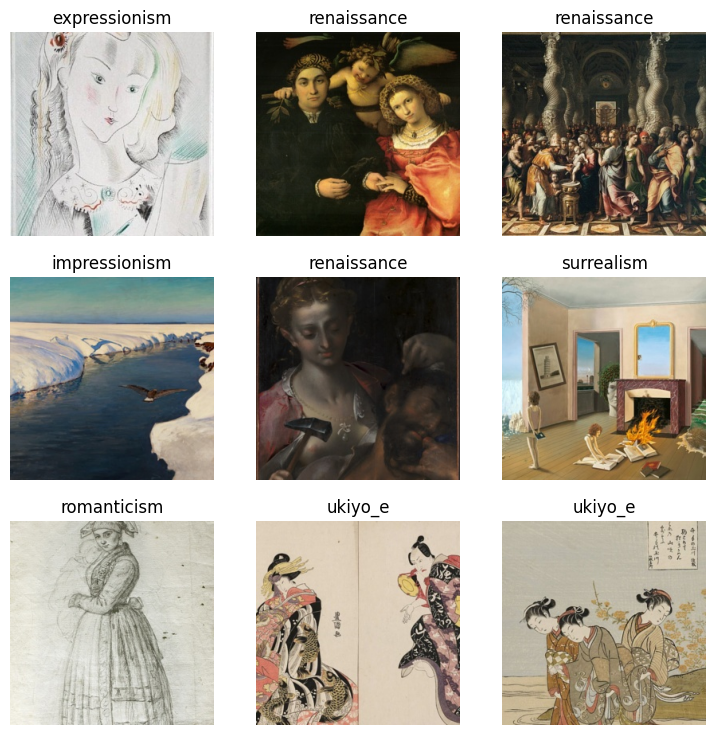

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET18_PRETRAINED

{'data_split': 'random', 'split_seed': 42, 'split_valid_pct': 0.2, 'batch_tfms': 'Normalize.from_stats(*imagenet_stats)', 'batch_size': 64, 'dataset_variation': 'reduced_artist_with_one_genre', 'model_name': 'resnet18_pretrained'}

metric: steep,  learning_rate:  0.001202
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: valley,  learning_rate:  0.001738
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.002512
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: minimum,  learning_rate:  0.010000
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



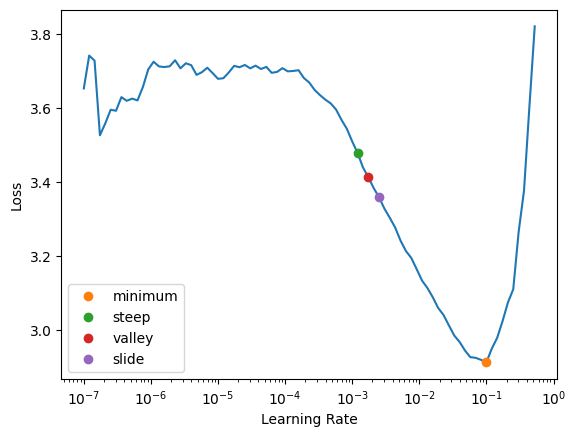

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(params_training_all_runs)
print()
format_lrs(learn_rate)

# Experiment

**14.) Train on reduced dataset:**


In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='014_resnet18_reduced_dateset') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.621108,1.200741,0.411407,01:26
1,1.370798,1.094912,0.383726,01:21
2,1.171881,1.029000,0.368213,01:22
3,1.140399,0.999554,0.362281,01:22
4,1.074291,0.978182,0.354068,01:22
5,1.056651,0.966824,0.351787,01:21
6,0.996810,0.939327,0.339772,01:22
7,0.967103,0.934838,0.335817,01:20
8,0.915953,0.916733,0.330038,01:22
9,0.910887,0.892859,0.321673,01:22


artifact_uri saved as model
runs:/0dcd6ca993ba4a4389bcaae817b2e278/fastai_model/fastai_resnet18_train_only_frozen.pkl


**15.) Train on reduced dataset early stoppage:**


In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='015_resnet18_reduced_dataset_early_stoppage') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'],
                        lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'],
                        cbs=[cb_mlflow, EarlyStoppingCallback(min_delta=0.001, patience=5)])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.611527,1.208963,0.410798,01:24
1,1.373959,1.080234,0.376426,01:23
2,1.185488,1.037972,0.366844,01:23
3,1.096689,1.000166,0.356654,01:23
4,1.077239,0.975538,0.358631,01:23
5,1.041308,0.965297,0.349658,01:23
6,1.007376,0.931117,0.341901,01:23
7,0.977825,0.929522,0.331863,01:23
8,0.943887,0.909586,0.331711,01:23
9,0.915192,0.881916,0.316958,01:23


No improvement since epoch 15: early stopping
artifact_uri saved as model
runs:/2d70ca9088614b3cb90b4b0a773827f2/fastai_model/fastai_resnet18_train_only_frozen.pkl


In [ ]:
run = get_last_run_id(mlfclient, '1')

In [ ]:
import pickle

def store_fastai_train_recordings(learn, run, vocabulary = None ):
  # save loss recording plot
  loss_plot_path = "loss_plot.png"
  learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)
  mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
          artifact_path='figures')

  interp = ClassificationInterpretation.from_learner(learn)

  # save interpretation object
  interp_path = "interpretation.pkl"
  with open(interp_path, "wb") as f:
      pickle.dump(interp, f)
  # Log the interpretation object as an artifact to the current MLflow run
  mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
          artifact_path='interpetation' )

  # save confussion matrix image
  if vocabulary is not None:
    # this needs to be performed after saving pickel object,
    # so that you can serialize it.
    add_methods_to_interpetation(interp)
    interp.plot_confusion_matrix_vocab(vocabulary, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')
  else:
    interp.plot_confusion_matrix(figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')

  mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
          artifact_path='figures' )

  # save learning rate and momentum comparison
  learn.recorder.plot_sched()
  plot_sched_figure = plt.gcf()
  image_plot_sched = 'scheduled_lr_mom.png'
  # you can retrieve the last image with this, since plot is bot returned
  # Now you can work with the last_figure object, e.g., save it
  plot_sched_figure.savefig(image_plot_sched)

  mlfclient.log_artifact(run.info.run_id, local_path=image_plot_sched,
          artifact_path='figures' )

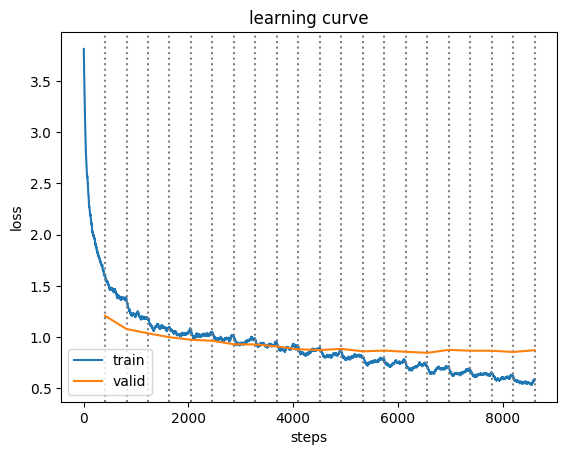

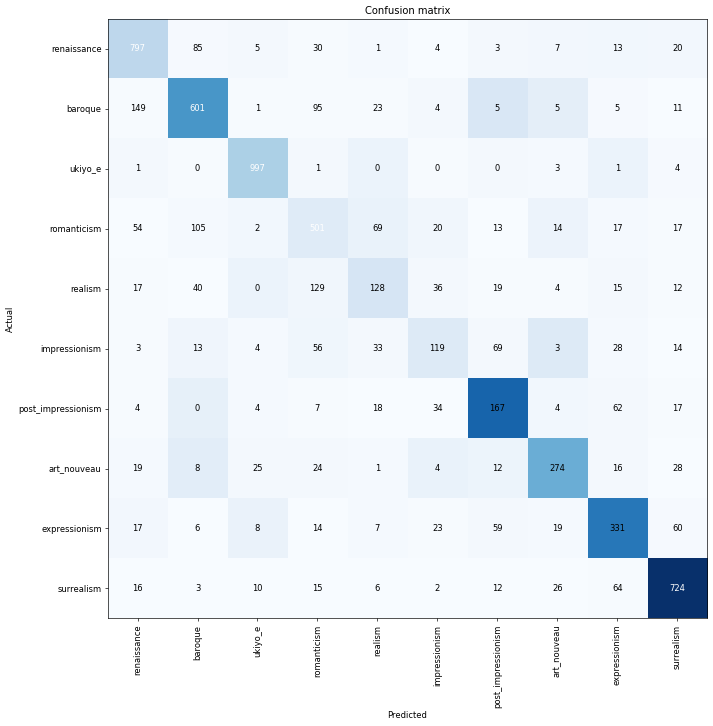

In [ ]:
store_fastai_train_recordings(learn, run, genres_sorted_era)

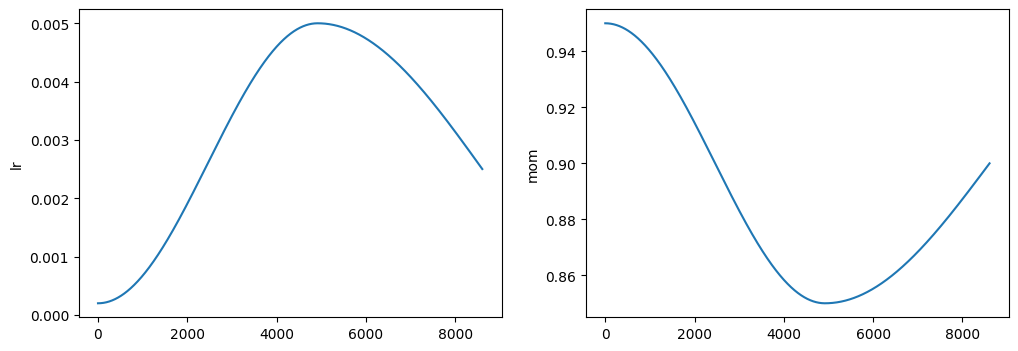

In [ ]:
learn.recorder.plot_sched()
plot_sched_figure = plt.gcf()

image_plot_sched = 'scheduled_lr_mom.png'

# you can retrieve the last image with this, since plot is bot returned

# Now you can work with the last_figure object, e.g., save it
plot_sched_figure.savefig(image_plot_sched)

mlfclient.log_artifact(run.info.run_id, local_path=image_plot_sched,
        artifact_path='figures' )


In [ ]:
# copy mlflow mlruns.db back to server
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

# copy mlflow_data back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data

# Interpretation of the results, in comparison with experiments on whole dataset

**Results from experiment 015**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.76      0.67      0.71       411
           baroque       0.70      0.67      0.68       899
     expressionism       0.60      0.61      0.60       544
     impressionism       0.48      0.35      0.40       342
post_impressionism       0.47      0.53      0.49       317
           realism       0.45      0.32      0.37       400
       renaissance       0.74      0.83      0.78       965
       romanticism       0.57      0.62      0.60       812
        surrealism       0.80      0.82      0.81       878
           ukiyo_e       0.94      0.99      0.97      1007

          accuracy                           0.71      6575
         macro avg       0.65      0.64      0.64      6575
      weighted avg       0.70      0.71      0.70      6575



In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [ ]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

('baroque', 'renaissance', 1, np.int64(149))
('realism', 'romanticism', 1, np.int64(129))
('romanticism', 'baroque', 2, np.int64(105))
('baroque', 'romanticism', 2, np.int64(95))
('renaissance', 'baroque', 1, np.int64(85))
('impressionism', 'post_impressionism', 1, np.int64(69))
('romanticism', 'realism', 1, np.int64(69))
('surrealism', 'expressionism', 1, np.int64(64))
('post_impressionism', 'expressionism', 2, np.int64(62))
('expressionism', 'surrealism', 1, np.int64(60))
('expressionism', 'post_impressionism', 2, np.int64(59))
('impressionism', 'romanticism', 2, np.int64(56))
('romanticism', 'renaissance', 3, np.int64(54))
('realism', 'baroque', 3, np.int64(40))
('realism', 'impressionism', 1, np.int64(36))
('post_impressionism', 'impressionism', 1, np.int64(34))
('impressionism', 'realism', 1, np.int64(33))
('renaissance', 'romanticism', 3, np.int64(30))
('art_nouveau', 'surrealism', 2, np.int64(28))
('impressionism', 'expressionism', 3, np.int64(28))
('surrealism', 'art_nouveau', 

**TODO Experiment 013, best result on whole dataset**

# Mlfow how to start server to view results in colab


In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

  16930 ?        Rl     0:00 /usr/bin/python3 /usr/local/bin/mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000


In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

MLflow Tracking UI: https://685ee7146c23.ngrok-free.app


'https://685ee7146c23.ngrok-free.app'

With MLflow, you can resume a run that has ended. This is a useful feature for continuing training from a checkpoint or adding more information to an existing run.

You can resume a run by using the mlflow.start_run() function with the run_id of the ended run.

# Evaluation on test dataset, this fails for some reason

In [ ]:
test_dataloaders = paintings.dataloaders(df[df['split'] == 'test'], with_labels=True)

TypeError: expected str, bytes or os.PathLike object, not DataFrame

In [ ]:
test_dataloaders

In [ ]:
predictions, targets = learn.get_preds(dl=test_dataloaders)
print(f"accuracy of of resnet 18 model on reduced dataset:")
accuracy(predictions, targets).item()

IndexError: index 5314 is out of bounds for dimension 0 with size 5312

In [ ]:
run_id_best_previous = find_run_id_by_code(mlfclient, active_experiment_id, '013')
run_id_best_previous

'4c86c27c616a43438a41de5dc4ac0a1b'

In [ ]:
!cp -r "/content/drive/My Drive/Colab Notebooks/mlflow_data/mlruns/{active_experiment_id}/{run_id_best_previous}/" "/content/mlruns/{active_experiment_id}/{run_id_best_previous}"


In [ ]:
import pickle
import mlflow

# Assuming you have the run_id of the run where you saved the interpretation
# Replace 'your_run_id' with the actual run ID
run_id = '4c86c27c616a43438a41de5dc4ac0a1b'

# Define the artifact path for the interpretation file
artifact_path = 'interpetation/interpretation.pkl' # Make sure this matches the path used during saving

# Download the artifact to a temporary directory
local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)

# Load the ClassificationInterpretation object from the downloaded pickle file
with open(local_path, 'rb') as f:
    loaded_interp = pickle.load(f, fix_imports=False)

# Now you have the loaded ClassificationInterpretation object
# You can use it to analyze results without needing the original learner
# For example:
loaded_interp.print_classification_report()
loaded_interp.plot_confusion_matrix()

AttributeError: 'ClassificationInterpretation' object has no attribute 'plot_confusion_matrix_vocab'

In [ ]:
# Clean up the downloaded artifact file
import os
os.remove(local_path)